In [271]:
!{sys.executable} -m pip install pandas 

  Using cached pandas-1.5.0-cp310-cp310-win_amd64.whl (10.4 MB)
  Using cached pytz-2022.4-py2.py3-none-any.whl (500 kB)


In [272]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths
import sys 
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import SelfTrainingClassifier
import pandas as pd



In [3]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])


In [318]:
#Amount of dataset should be handled
N_datasets = 3

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))
    

print(open_files_array[0])

[[[ 315  431 2280 ... 1829 1678 2027]
  [ 332  425 1661 ... 1392 1324 1674]
  [ 325  436 2552 ... 1974 2062 2075]
  ...
  [ 327  387 4691 ... 6762 6095 6462]
  [ 327  382 6225 ... 9399 7239 7261]
  [ 323  366 5418 ... 7678 7266 7890]]

 [[ 331  461 1946 ... 2101 2096 2072]
  [ 327  431 1477 ... 1696 1700 1655]
  [ 316  441 2119 ... 2284 2253 2248]
  ...
  [ 324  391 5016 ... 5985 5858 5860]
  [ 331  392 5425 ... 6390 6312 6019]
  [ 329  379 5151 ... 6327 6078 6123]]

 [[ 347  481 1828 ... 2091 2096 2074]
  [ 347  450 1416 ... 1701 1659 1666]
  [ 343  467 2041 ... 2275 2281 2280]
  ...
  [ 348  417 5002 ... 5862 5830 5652]
  [ 339  401 5195 ... 5965 6053 5857]
  [ 351  400 5127 ... 5992 5857 5840]]

 ...

 [[ 323  453 2793 ... 2201 2169 2169]
  [ 335  480 2457 ... 1891 1846 1891]
  [ 320  586 2577 ... 2246 2217 2242]
  ...
  [ 316  405 7111 ... 5574 5523 5667]
  [ 340  408 7556 ... 5984 5971 6030]
  [ 323  378 7702 ... 6325 6381 5931]]

 [[ 363  494 2731 ... 2207 2174 2173]
  [ 373  514

In [336]:
data = open_files_array[0]
labels = load_labels_array[0]

data_test = open_files_array[2]
labels_test = load_labels_array[2]


In [345]:
def preprocesing_data(data,labels): 
    # prepare data
    X = data.transpose(0,2,1).reshape((-1,61))
    y = labels.flatten()

    X = preprocessing.scale(X, axis=0)                    # Normalization
    #X = preprocessing.normalize(X, axis=0) 
    return X,y 

X,y = preprocesing_data(data,labels)
"""
#Make a dataframe of the hyperspectral pictures
data = {"Data" : X, "Labels": y}

df = pd.DataFrame(data)
"""

#Test this tomorrow. 

"""
X = np.array(X)
print(len(X))

X_test,y_test = preprocesing_data(data_test,labels_test)

print(len(X_test))
X = np.append(X,X_test)

print(len(X))
"""

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


1000000


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


1000000
122000000


In [333]:

"""
# prepare data
X = data.transpose(0,2,1).reshape((-1,61))
y = labels.flatten()

X = preprocessing.scale(X, axis=0)                    # Normalization
#X = preprocessing.normalize(X, axis=0)             # Standardization
print(X.shape, y.shape)
"""
"""
X_array, y_array = [],[]

X,y = preprocesing_data(data=data, labels=labels)
    
X_array.append(X)
y_array.append(y)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.999, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

"""
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(df, test_size=0.999, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)




ValueError: not enough values to unpack (expected 4, got 2)

In [283]:
class_weights = {0: 1, 1: 1, 2: 1, 3: 10 , 4:1, 5:1}

In [284]:
#Linear SVM 
# Generate SVM from training data
# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other

#svma = LinearSVC(max_iter=1e5, tol=1e-5, class_weight=class_weights)
svma = SVC(
    C = 10,
    kernel = "rbf", 
    degree = 3,
    gamma = "scale", 
    coef0 = 0.0, 
    probability = True, 
    tol = 1e-3, 
    cache_size = 400,
    class_weight = class_weights, 
    verbose = True, 
    max_iter = 1e3, 
    decision_function_shape = "ovr",
    break_ties = True, 
    random_state = 1
)

svma.fit(X_train, y_train)
print("support vectors:", len(svma.support_))

[LibSVM]support vectors: 892


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [264]:
#Decision Tree 
#Make the different models. 



In [285]:
# calculate overall accuracy on Training data
(svma.predict(X_train)==y_train).sum()/len(y_train)

0.387

In [286]:
# Accuracy on test data
(svma.predict(X_test)==y_test).sum()/len(y_test)

0.37091391391391393

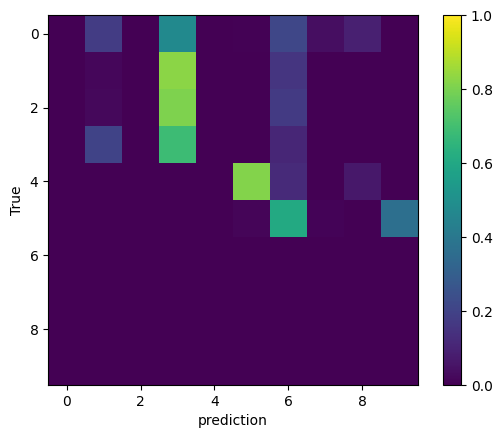

In [288]:
Xout = svma.predict(X_tester)

plt.imshow(Xout.reshape((1000,1000)))

cm = confusion_matrix(labels_test.flatten(), Xout, normalize='true')

plt.imshow(cm, vmax=1, vmin=0)
plt.ylabel('True')
plt.xlabel('prediction')
plt.colorbar()

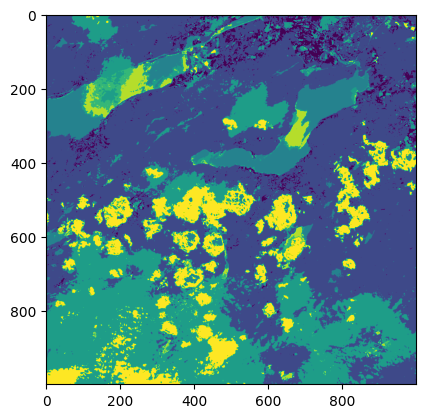

In [290]:
plt.imshow(Xout.reshape((1000,1000)))

In [269]:
print(svma.score(X_tester, y_tester))

0.711318
